In [132]:
import pandas as pd

import boto3
import io

# Initialize a boto3 session
session = boto3.Session()

# Create an S3 client
s3 = session.client('s3')

# Define S3 bucket and object keys
bucket = 'asm-dataset'
k8s_data_key = 'k8scaling/TestK8sData.csv'
jmeter_data_key = 'k8scaling/TestJMeterData.csv'
train_data_key = 'k8scaling/TrainData.csv'


# Function to load data from S3 into a DataFrame
def load_data_from_s3(bucket, key):
    response = s3.get_object(Bucket=bucket, Key=key)
    data = response['Body'].read()
    df = pd.read_csv(io.BytesIO(data))
    return df


# Load the datasets
test_k8s_data = load_data_from_s3(bucket, k8s_data_key)
test_jmeter_data = load_data_from_s3(bucket, jmeter_data_key)
train_data = load_data_from_s3(bucket, train_data_key)

# Preview the data
print(test_k8s_data.head())
print(test_jmeter_data.head())
print(train_data.head())

              Timestamp        CPU  PackRecv  PodsNumber  Duration  \
0  24-Jul-2023 22:13:16   0.476825  0.000000           1  00:00:00   
1  24-Jul-2023 22:13:18   0.476825  2.356443           1  00:00:02   
2  24-Jul-2023 22:13:20   0.476825  2.356443           1  00:00:04   
3  24-Jul-2023 22:13:22  10.677100  2.356443           1  00:00:06   
4  24-Jul-2023 22:13:24  10.677100  2.356443           1  00:00:08   

   InitialPodsNumber  StressUpRate  Experiment Type  CPUThreshold  
0                  1             5           1  HPA            10  
1                  1             5           1  HPA            10  
2                  1             5           1  HPA            10  
3                  1             5           1  HPA            10  
4                  1             5           1  HPA            10  
                 timeStamp  elapsed         label  responseCode  \
0  24-07-2023 22:13:10.914      709  HTTP Request         200.0   
1  24-07-2023 22:13:12.579        9  

#### EDA

#### To explore TestK8sData.csv dataset by Grouping the experiments

To display the relationship between CPU usage and the number of pods, separated by type (ANN vs. HPA)

In [133]:
# Extract the last entry of each experiment for the duration
last_entries = test_k8s_data.groupby(['Experiment', 'Type']).agg({
    'Duration': 'last'  # Get the last duration entry per group
}).reset_index()

# Calculate mean values for other metrics and round PodsNumber
test_k8s_metrics_mean = test_k8s_data.groupby(['Experiment', 'Type']).agg({
    'CPU': 'mean',
    'PackRecv': 'mean',
    'PodsNumber': lambda x: round(x.mean()),  # Round the mean to nearest integer
    'StressUpRate': 'mean',
    'CPUThreshold': 'mean'
}).reset_index()

# Merge the two DataFrames
test_k8s_grouped_data = pd.merge(test_k8s_metrics_mean, last_entries, on=['Experiment', 'Type'])

print(test_k8s_grouped_data)

   Experiment Type        CPU    PackRecv  PodsNumber  StressUpRate  \
0           1  ANN  28.270876   33.475148           4     49.198937   
1           1  HPA  36.708707   18.270614          12     52.491497   
2           2  HPA  51.070508   57.806740           4     52.669516   
3           3  HPA  69.006756  170.609704           1     52.664380   

   CPUThreshold  Duration  
0           0.0  00:02:47  
1          10.0  00:02:54  
2          40.0  00:02:54  
3          80.0  00:02:54  


The data was grouped based on experiments and type (ANN vs. HPA), allowing for a detailed examination of how different metrics such as CPU usage, packet reception rate, stress update rate, and CPU thresholds influence pod scaling decisions.

CPUThreshold: This metric defines the CPU usage threshold at which pod scaling decisions are triggered. Higher thresholds indicate a tolerance for higher CPU usage before scaling up, which can influence the efficiency and responsiveness of pod allocation in response to changing workloads.


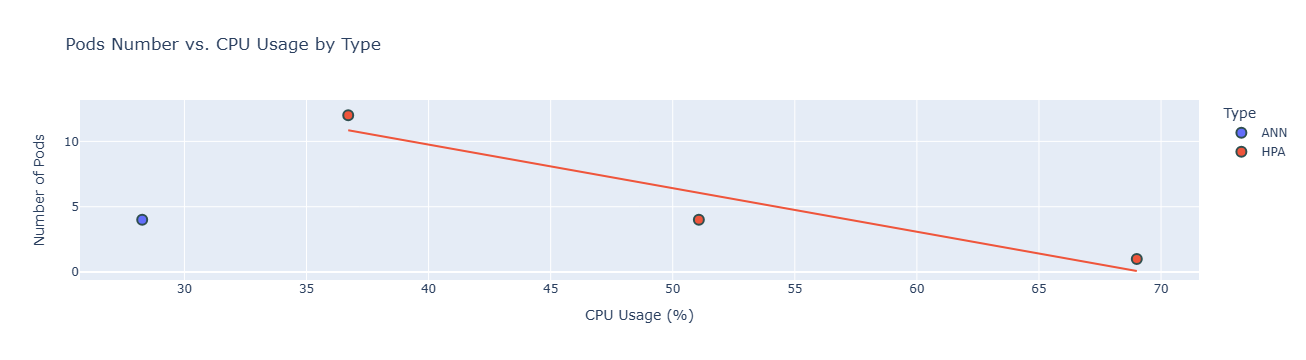

In [134]:
import pandas as pd
import plotly.express as px

# Visualization for PodsNumber vs. CPU
fig_cpu = px.scatter(test_k8s_grouped_data, x='CPU', y='PodsNumber', color='Type',
                     title='Pods Number vs. CPU Usage by Type',
                     labels={'PodsNumber': 'Number of Pods', 'CPU': 'CPU Usage (%)'},
                     trendline='ols')
fig_cpu.update_traces(marker=dict(size=10, line=dict(width=2,
                                                     color='DarkSlateGrey')),
                      selector=dict(mode='markers'))
fig_cpu.show()

Pods Number vs. CPU Usage: This visualization shows a declining trend in the number of pods as CPU usage increases for HPA, whereas for ANN, the number of pods remains relatively low, indicating a less reactive scaling behavior to CPU usage.

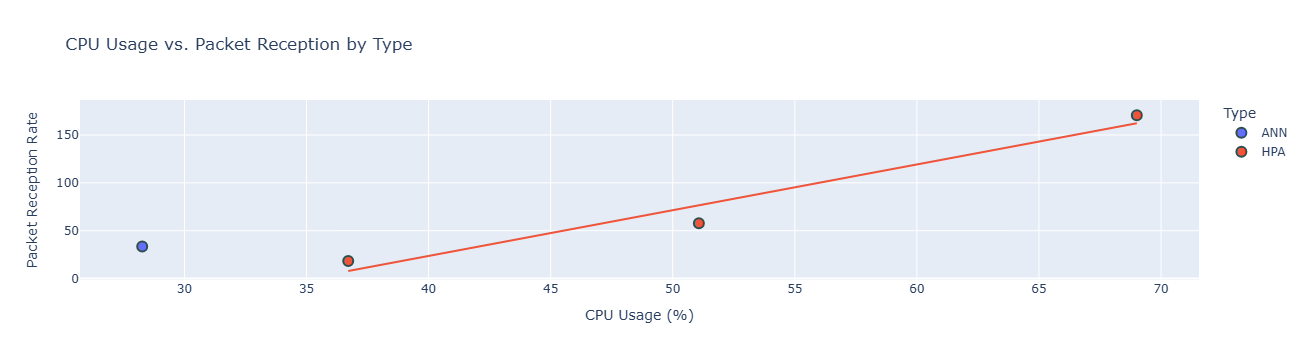

In [135]:
# Visualization for CPU vs. PackRecv
fig_packrecv = px.scatter(test_k8s_grouped_data, x='CPU', y='PackRecv', color='Type',
                          title='CPU Usage vs. Packet Reception by Type',
                          labels={'PackRecv': 'Packet Reception Rate', 'CPU': 'CPU Usage (%)'},
                          trendline='ols')
fig_packrecv.update_traces(marker=dict(size=10, line=dict(width=2,
                                                          color='DarkSlateGrey')),
                           selector=dict(mode='markers'))
fig_packrecv.show()

CPU Usage vs. Packet Reception Rate: Here, both types exhibit a positive correlation, with packet reception rates increasing as CPU usage rises, suggesting that higher network activity correlates with increased CPU load.

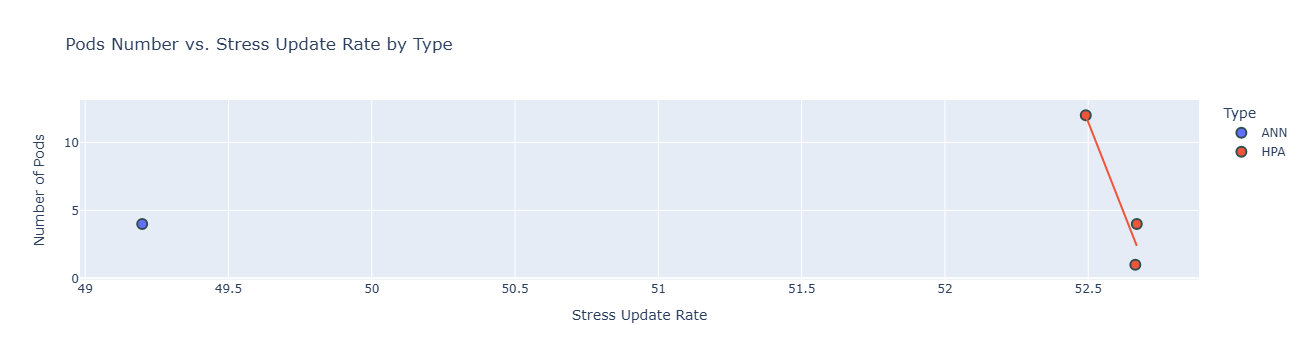

In [136]:
# Visualization for PodsNumber vs. StressUpRate
fig_stress = px.scatter(test_k8s_grouped_data, x='StressUpRate', y='PodsNumber', color='Type',
                        title='Pods Number vs. Stress Update Rate by Type',
                        labels={'PodsNumber': 'Number of Pods', 'StressUpRate': 'Stress Update Rate'},
                        trendline='ols')
fig_stress.update_traces(marker=dict(size=10, line=dict(width=2,
                                                        color='DarkSlateGrey')),
                         selector=dict(mode='markers'))
fig_stress.show()

Pods Number vs. Stress Update Rate: For HPA, there is a significant increase in the number of pods with a slight increase in stress update rates, highlighting its sensitivity to stress changes. The ANN type shows less variability, maintaining a lower number of pods regardless of stress updates, suggesting a different or possibly more conservative scaling strategy under stress conditions.

#### To explore TestJMeterData.csv dataset by Grouping the experiments

In [137]:
# Group the data by 'Experiment' and 'Type', and calculate the mean for the metrics
grouped_jmeter_data = test_jmeter_data.groupby(['Experiment', 'Type']).mean().reset_index()


/tmp/ipykernel_9478/4035247172.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [138]:
grouped_jmeter_data

,Experiment,Type,elapsed,responseCode,success,bytes,sentBytes,grpThreads,allThreads,Latency,SampleCount,ErrorCount,IdleTime,Connect,InitialPodsNumber,StressUpRate,CPUThreshold
0,1,ANN,297.994031,201.606689,0.533026,1575.218644,78.236717,21.166410,21.166370,237.242313,1.0,0.466974,0.0,4.163854,1.0,68.334788,0.0
1,1,HPA,248.530455,200.000000,0.851361,643.349012,124.298738,15.093365,15.093412,248.404985,1.0,0.148639,0.0,0.646718,1.0,68.334788,10.0
2,2,HPA,273.145194,200.000000,0.861751,612.429225,125.815636,18.621160,18.621200,273.041448,1.0,0.138249,0.0,0.569617,1.0,68.334788,40.0
3,3,HPA,142.079197,200.000000,0.960386,318.880260,140.216319,12.624478,12.624335,142.009048,1.0,0.039614,0.0,0.538487,1.0,68.334788,80.0


 The TestJMeterData dataset provides detailed test data on HTTP requests, including response times, success rates, and throughput metrics. These metrics are crucial for evaluating the performance under simulated load conditions. The corresponding TestK8sData dataset complements this by documenting Kubernetes' scaling performance for these test scenarios, detailing the number of pods utilized and CPU stress levels. Together, these datasets offer a comprehensive view of the system’s behavior under varying loads, enabling a thorough analysis of both the application’s responsiveness and the efficiency of Kubernetes' horizontal scaling mechanism.

#### Combined EDA test_jmeter_data & test_k8s_data

In [139]:
#Average CPU Usage Over Time By Test Type

# Combine CPU usage and timestamp data for plotting
combined_cpu_usage = pd.DataFrame({
    "Timestamp": pd.concat([test_jmeter_data['timeStamp'], test_k8s_data['Timestamp']]),
    "CPU": pd.concat([test_jmeter_data['CPUThreshold'], test_k8s_data['CPU']]),
    "Type": pd.concat([test_jmeter_data['Type'], test_k8s_data['Type']])
})


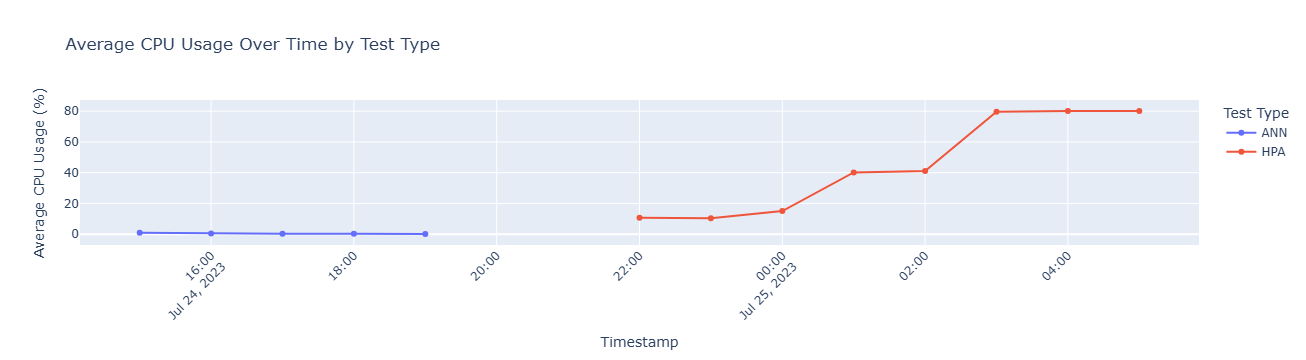

In [140]:
import pandas as pd
import plotly.express as px

# Convert 'Timestamp' to datetime if it's not already
combined_cpu_usage['Timestamp'] = pd.to_datetime(combined_cpu_usage['Timestamp'])

# Resample or group by hour and 'Type'
grouped_data = combined_cpu_usage.groupby([pd.Grouper(key='Timestamp', freq='H'), 'Type']).mean().reset_index()

# Plotting with Plotly
fig = px.line(grouped_data, x='Timestamp', y='CPU', color='Type', markers=True,
              labels={
                  "CPU": "Average CPU Usage (%)",
                  "Timestamp": "Time",
                  "Type": "Test Type"
              },
              title='Average CPU Usage Over Time by Test Type')
fig.update_layout(xaxis_title='Timestamp',
                  yaxis_title='Average CPU Usage (%)',
                  legend_title='Test Type')
fig.update_xaxes(tickangle=-45)

fig.show()


This visualization presents aggregated CPU usage over time, differentiated by test type (ANN vs. HPA) for Kubernetes clusters. By averaging CPU loads over hourly intervals, we can clearly see trends in resource utilization for each scaling strategy.an easy comparison of how each model adapts to changes in load over time, demonstrating the ANN model's responsiveness and its potential for optimizing resource allocation in dynamic environments. 

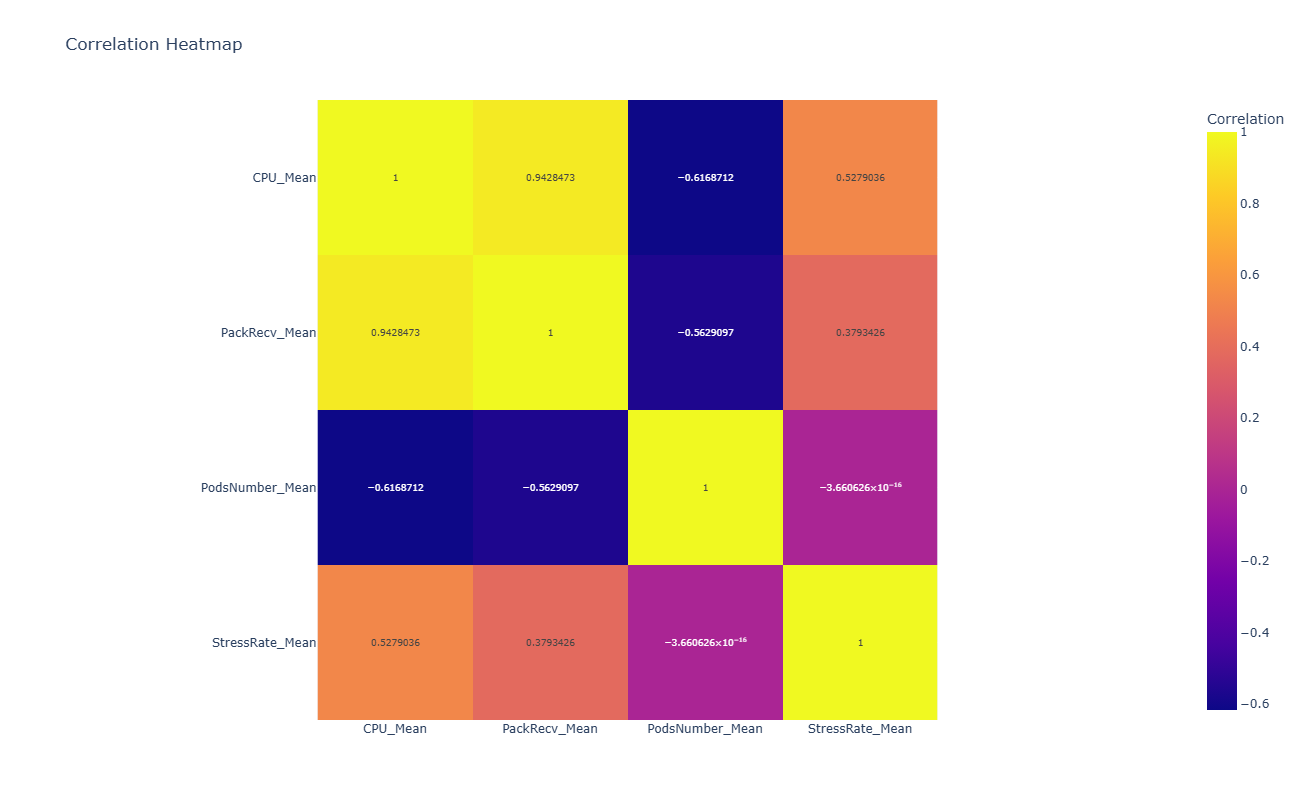

In [141]:
# Correlation Heatmap - Training Dataset
fig_heatmap = px.imshow(train_data.corr(), text_auto=True, title="Correlation Heatmap", labels=dict(color="Correlation"))
fig_heatmap.update_layout(
    width=1000,  # Adjust width
    height=800  # Adjust height
)
fig_heatmap.show()

#### Normalize the Test dataset & Merge it with Training dataset

In [142]:
test_k8s_grouped_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Experiment    4 non-null      int64  
 1   Type          4 non-null      object 
 2   CPU           4 non-null      float64
 3   PackRecv      4 non-null      float64
 4   PodsNumber    4 non-null      int64  
 5   StressUpRate  4 non-null      float64
 6   CPUThreshold  4 non-null      float64
 7   Duration      4 non-null      object 
dtypes: float64(4), int64(2), object(2)
memory usage: 288.0+ bytes


In [145]:
# Rename columns in the test dataset to match the training dataset
test_k8s_grouped_data.rename(columns={
   'CPU' :  'CPU_Mean', 
   'PackRecv' : 'PackRecv_Mean',
    'PodsNumber' : 'PodsNumber_Mean',
   'StressUpRate' : 'StressRate_Mean'
}, inplace=True)

In [146]:
test_k8s_grouped_data.info(), train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Experiment       4 non-null      int64  
 1   Type             4 non-null      object 
 2   CPU_Mean         4 non-null      float64
 3   PackRecv_Mean    4 non-null      float64
 4   PodsNumber_Mean  4 non-null      int64  
 5   StressRate_Mean  4 non-null      float64
 6   CPUThreshold     4 non-null      float64
 7   Duration         4 non-null      object 
dtypes: float64(4), int64(2), object(2)
memory usage: 288.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CPU_Mean         1000 non-null   float64
 1   PackRecv_Mean    1000 non-null   float64
 2   PodsNumber_Mean  1000 non-null   int64  
 3   StressRate_Mean  1000 non-null   

(None, None)

In [147]:
# Concatenate the datasets vertically to combine rows
merged_data = pd.concat([train_data, test_k8s_grouped_data], ignore_index=True)

In [148]:
from sklearn.utils import shuffle
merged_data = shuffle(merged_data, random_state=42)

In [150]:
import numpy as np
# Fill missing values with the mean or median
merged_data['CPU_Mean'].fillna(merged_data['CPU_Mean'].mean(), inplace=True)
merged_data['PackRecv_Mean'].fillna(merged_data['PackRecv_Mean'].mean(), inplace=True)

# Removing outliers
from scipy import stats
merged_data = merged_data[(np.abs(stats.zscore(merged_data['CPU_Mean'])) < 3)]
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 955 entries, 926 to 102
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CPU_Mean         955 non-null    float64
 1   PackRecv_Mean    955 non-null    float64
 2   PodsNumber_Mean  955 non-null    int64  
 3   StressRate_Mean  955 non-null    float64
 4   Experiment       4 non-null      float64
 5   Type             4 non-null      object 
 6   CPUThreshold     4 non-null      float64
 7   Duration         4 non-null      object 
dtypes: float64(5), int64(1), object(2)
memory usage: 67.1+ KB


#### Feature Engineering

In [151]:
import numpy as np
import pandas as pd

# Ensure no zeros in denominators
merged_data['PackRecv_Mean'] = merged_data['PackRecv_Mean'].replace(0, np.finfo(float).tiny)

# Safely compute ratios
merged_data['CPU_Pack_Ratio'] = merged_data['CPU_Mean'] / merged_data['PackRecv_Mean']

# Normalize the CPU_Pack_Ratio to avoid extreme values
merged_data['CPU_Pack_Ratio'] = np.clip(merged_data['CPU_Pack_Ratio'], np.percentile(merged_data['CPU_Pack_Ratio'], 1), np.percentile(merged_data['CPU_Pack_Ratio'], 99))

# Apply a logarithmic transformation, adding a small constant to avoid log(0)
merged_data['CPU_Pack_Ratio_Log'] = np.log(merged_data['CPU_Pack_Ratio'] + 1e-10)

# Replace any remaining infinite or extreme values that might still cause issues
merged_data.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_data.fillna(merged_data.mean(), inplace=True)  # Replace NaNs with the column mean

# Check descriptions after transformations
print(merged_data.describe(include='all'))


          CPU_Mean  PackRecv_Mean  PodsNumber_Mean  StressRate_Mean  \
count   955.000000     955.000000       955.000000       955.000000   
unique         NaN            NaN              NaN              NaN   
top            NaN            NaN              NaN              NaN   
freq           NaN            NaN              NaN              NaN   
mean     23.290765      38.578062        10.939267        48.592696   
std      18.421310      38.972273         5.538362        28.637412   
min       1.384639       0.278071         1.000000         1.000000   
25%      10.236201      13.629487         6.000000        23.000000   
50%      17.406317      26.951862        11.000000        47.000000   
75%      31.163931      48.042365        16.000000        73.000000   
max      86.550704     263.892834        20.000000        99.000000   

        Experiment Type  CPUThreshold  Duration  CPU_Pack_Ratio  \
count    955.00000    4    955.000000         4      955.000000   
unique       

/tmp/ipykernel_9478/814365687.py:18: FutureWarning:

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.



In [152]:
import numpy as np
import pandas as pd

# Ensure all PackRecv_Mean values are greater than a tiny positive number
merged_data['PackRecv_Mean'] = merged_data['PackRecv_Mean'].replace(0, np.finfo(float).tiny)
merged_data['PackRecv_Mean'] = np.where(merged_data['PackRecv_Mean'] < 1e-10, 1e-10, merged_data['PackRecv_Mean'])

# Recalculate CPU_Pack_Ratio with safe checks
merged_data['CPU_Pack_Ratio'] = merged_data['CPU_Mean'] / merged_data['PackRecv_Mean']

# Clip extreme values in CPU_Pack_Ratio before log transformation
cap_high = np.percentile(merged_data['CPU_Pack_Ratio'], 99)  # Cap at 99th percentile
merged_data['CPU_Pack_Ratio'] = np.clip(merged_data['CPU_Pack_Ratio'], None, cap_high)

# Apply log transformation
merged_data['CPU_Pack_Ratio_Log'] = np.log(merged_data['CPU_Pack_Ratio'] + 1e-10)  # Adding a small constant to avoid log(0)

# Fill NaN values that could appear after handling extremes
merged_data['CPU_Pack_Ratio_Log'] = merged_data['CPU_Pack_Ratio_Log'].fillna(merged_data['CPU_Pack_Ratio_Log'].mean())

# Print out final stats to check if the issue is resolved
print("Final CPU_Pack_Ratio_Log statistics:", merged_data['CPU_Pack_Ratio_Log'].describe())




Final CPU_Pack_Ratio_Log statistics: count    955.000000
mean      -0.339603
std        0.316480
min       -1.151299
25%       -0.537884
50%       -0.406159
75%       -0.163967
max        1.154315
Name: CPU_Pack_Ratio_Log, dtype: float64


In [153]:
# Check raw statistics before scaling for CPU_Pack_Ratio
print("Pre-scaling CPU_Pack_Ratio stats:")
print(merged_data['CPU_Pack_Ratio'].describe())

Pre-scaling CPU_Pack_Ratio stats:
count    955.000000
mean       0.757293
std        0.353286
min        0.316226
25%        0.583983
50%        0.666205
75%        0.848770
max        3.171849
Name: CPU_Pack_Ratio, dtype: float64


In [154]:

import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Applying logarithmic transformation to reduce skewness for CPU_Pack_Ratio
merged_data['CPU_Pack_Ratio_Log'] = np.log1p(merged_data['CPU_Pack_Ratio'])

# Cap the CPU_Pack_Ratio_Log at the 99th percentile to handle extreme values
ratio_cap_log = merged_data['CPU_Pack_Ratio_Log'].quantile(0.99)
merged_data['CPU_Pack_Ratio_Log'] = np.where(merged_data['CPU_Pack_Ratio_Log'] > ratio_cap_log, ratio_cap_log, merged_data['CPU_Pack_Ratio_Log'])

# Prepare DataFrame for scaling
features_to_scale = ['CPU_Mean', 'PackRecv_Mean', 'StressRate_Mean', 'CPU_Pack_Ratio_Log']
merged_data[features_to_scale] = merged_data[features_to_scale] 

# Rescale all selected features
scaler = MinMaxScaler()
merged_data[features_to_scale] = scaler.fit_transform(merged_data[features_to_scale])



In [155]:
# Update feature list to include the log-transformed ratio
features_updated = ['CPU_Mean', 'PackRecv_Mean', 'StressRate_Mean', 'CPU_Pack_Ratio_Log']
print("Updated features statistics post final transformation:")
print(merged_data[features_updated].describe())

Updated features statistics post final transformation:
         CPU_Mean  PackRecv_Mean  StressRate_Mean  CPU_Pack_Ratio_Log
count  955.000000     955.000000       955.000000          955.000000
mean     0.257217       0.145288         0.485640            0.241608
std      0.216299       0.147838         0.292218            0.134897
min      0.000000       0.000000         0.000000            0.000000
25%      0.103933       0.050647         0.224490            0.162775
50%      0.188123       0.101185         0.469388            0.207259
75%      0.349661       0.181190         0.734694            0.298654
max      1.000000       1.000000         1.000000            1.000000


In [156]:
# Check for any remaining infinite or NaN values
print("Final check for NaN or inf values:")
print(merged_data[features_updated].isna().sum())
print(merged_data[features_updated].replace([np.inf, -np.inf], np.nan).isna().sum())

# View statistics to confirm scaling and data integrity
print("\nFinal data statistics:")
print(merged_data[features_updated].describe())

Final check for NaN or inf values:
CPU_Mean              0
PackRecv_Mean         0
StressRate_Mean       0
CPU_Pack_Ratio_Log    0
dtype: int64
CPU_Mean              0
PackRecv_Mean         0
StressRate_Mean       0
CPU_Pack_Ratio_Log    0
dtype: int64

Final data statistics:
         CPU_Mean  PackRecv_Mean  StressRate_Mean  CPU_Pack_Ratio_Log
count  955.000000     955.000000       955.000000          955.000000
mean     0.257217       0.145288         0.485640            0.241608
std      0.216299       0.147838         0.292218            0.134897
min      0.000000       0.000000         0.000000            0.000000
25%      0.103933       0.050647         0.224490            0.162775
50%      0.188123       0.101185         0.469388            0.207259
75%      0.349661       0.181190         0.734694            0.298654
max      1.000000       1.000000         1.000000            1.000000


In [157]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 955 entries, 926 to 102
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CPU_Mean            955 non-null    float64
 1   PackRecv_Mean       955 non-null    float64
 2   PodsNumber_Mean     955 non-null    int64  
 3   StressRate_Mean     955 non-null    float64
 4   Experiment          955 non-null    float64
 5   Type                4 non-null      object 
 6   CPUThreshold        955 non-null    float64
 7   Duration            4 non-null      object 
 8   CPU_Pack_Ratio      955 non-null    float64
 9   CPU_Pack_Ratio_Log  955 non-null    float64
dtypes: float64(7), int64(1), object(2)
memory usage: 82.1+ KB


/tmp/ipykernel_9478/2645940038.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



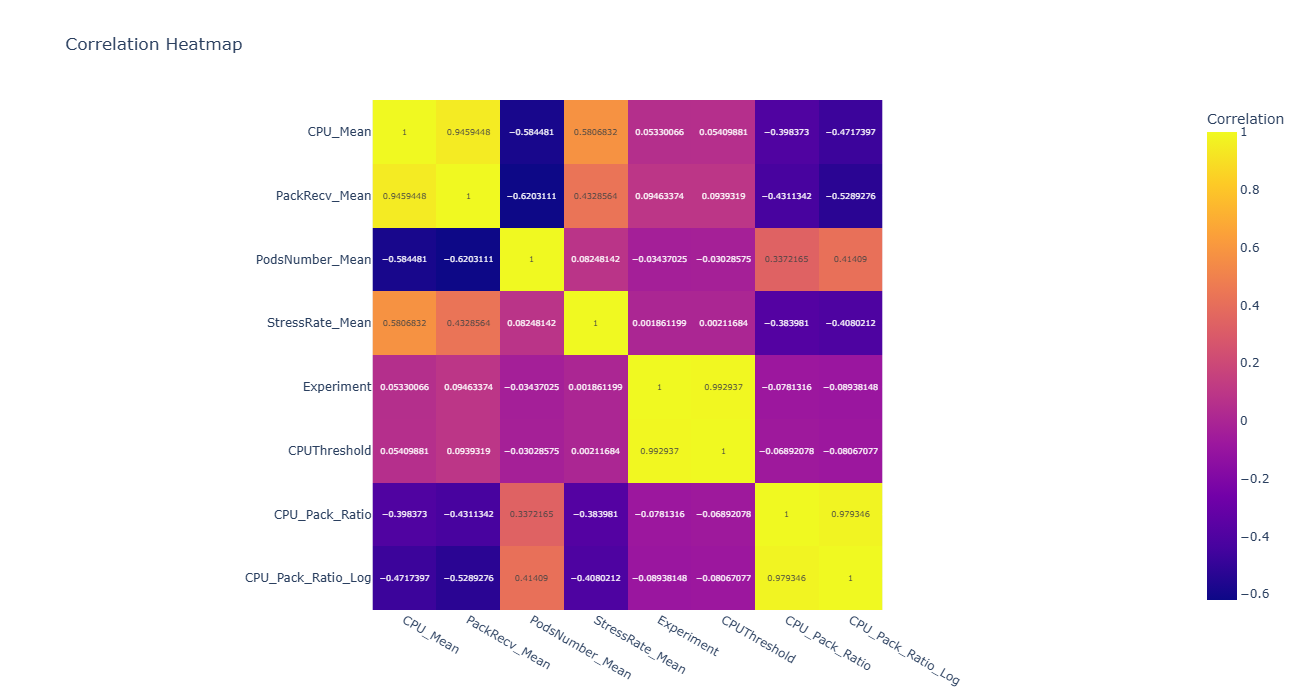

In [158]:
# Correlation Heatmap - Training Dataset
fig_heatmap_feature = px.imshow(merged_data.corr(), text_auto=True, title="Correlation Heatmap", labels=dict(color="Correlation"))
fig_heatmap_feature.update_layout(
    width=1000,  # Adjust width
    height=700  # Adjust height
)
fig_heatmap_feature.show()

In [168]:
# Drop unnecessary columns from the training dataset
merged_data = merged_data.drop(columns=['Experiment', 'CPUThreshold', 'CPU_Pack_Ratio'])

/tmp/ipykernel_9478/2645940038.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



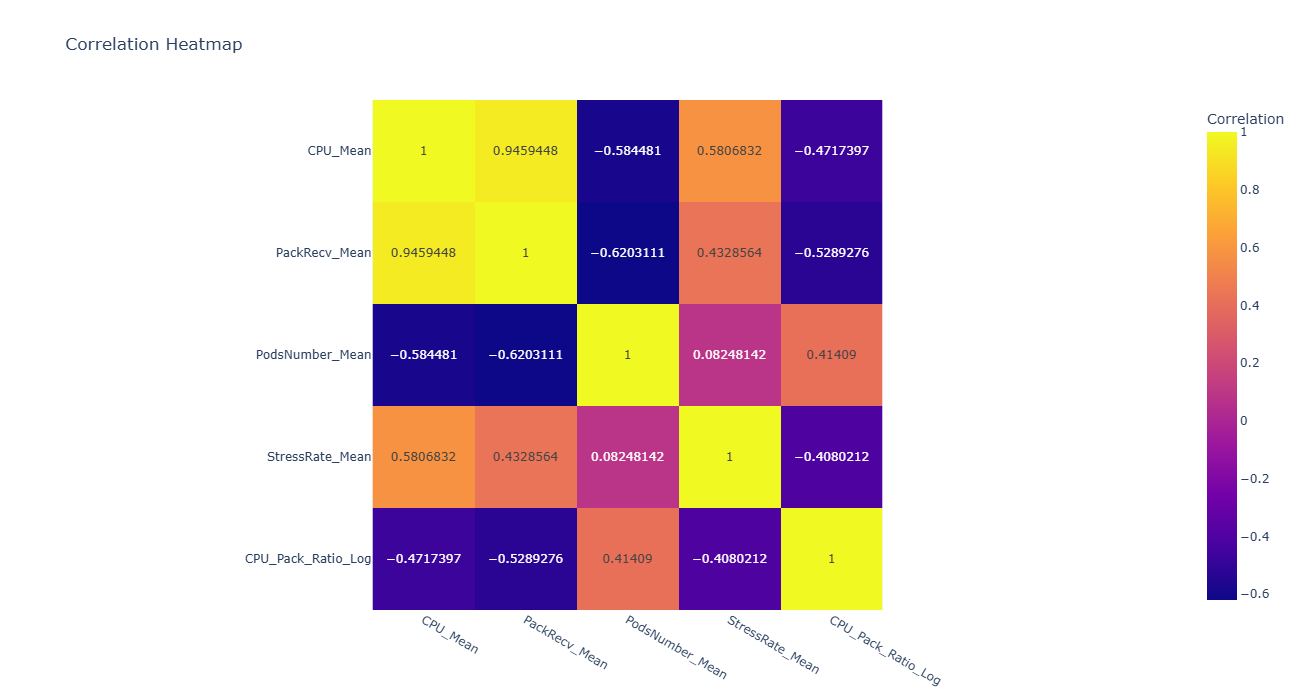

In [169]:
# Correlation Heatmap - Training Dataset
fig_heatmap_feature = px.imshow(merged_data.corr(), text_auto=True, title="Correlation Heatmap", labels=dict(color="Correlation"))
fig_heatmap_feature.update_layout(
    width=1000,  # Adjust width
    height=700  # Adjust height
)
fig_heatmap_feature.show()

CPU_Mean and PackRecv_Mean are highly positively correlated (0.95). This indicates that as CPU usage increases, the packet reception tends to increase as well.
PodsNumber_Mean has a moderate negative correlation with both CPU_Mean (-0.58) and PackRecv_Mean (-0.62). This suggests that as CPU usage or packet reception increases, the number of pods tends to decrease.
PodsNumber_Mean has a weak positive correlation with StressRate_Mean (0.08). This indicates that the stress rate might not have a strong impact on the number of pods.
PodsNumber_Mean shows a weak positive correlation (0.41) with CPU_Pack_Ratio_Log, suggesting some relationship, though not very strong.

For predicting PodsNumber_Mean, the most important features appear to be CPU_Mean and PackRecv_Mean

#### Data Splitting

In [170]:
from sklearn.model_selection import train_test_split

# 'merged_data' is DataFrame and 'features_updated' contains feature column names
X = merged_data[features_updated]
y = merged_data['PodsNumber_Mean']  # 'PodsNumber_Mean' is the target column

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#### Model Building

In [171]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Build the neural network model
model = Sequential([
    Dense(128, activation='relu', input_dim=len(features_updated)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')  # Output layer for regression
])

model.compile(optimizer='adam', loss='mean_squared_error')

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



#### Model Training

In [172]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 140.0976 - val_loss: 136.8525
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 111.6620 - val_loss: 64.1666
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 43.2320 - val_loss: 33.6996
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 28.8949 - val_loss: 23.1897
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.8651 - val_loss: 15.3890
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.8288 - val_loss: 11.2204
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.0967 - val_loss: 9.6909
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.3385 - val_loss: 8.8399
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.1821 - val_loss: 8.2230
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.2664 - val_loss: 7.5760
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.2928 - val_loss: 7.0152
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 

#### Performance Evaluation

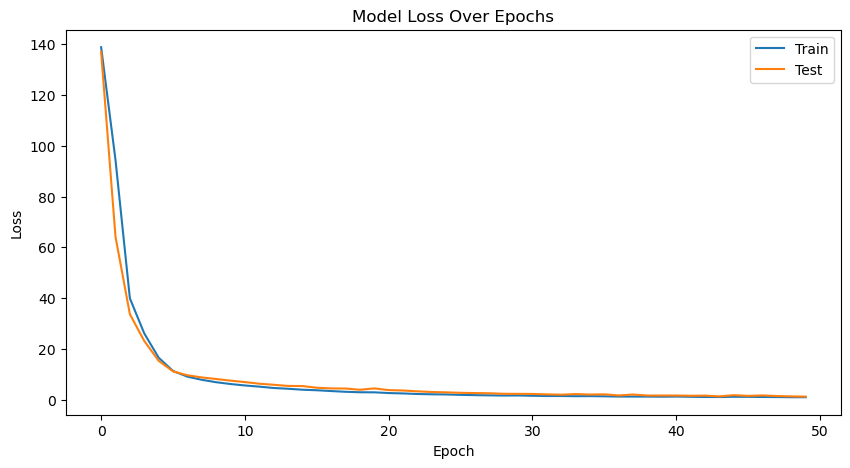

In [173]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [174]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
predictions = model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [175]:
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error (MAE): {mae}")
r2 = r2_score(y_test, predictions)
print(f"R-squared (R^2): {r2}")

Root Mean Squared Error (RMSE): 1.1357095964631425
Mean Absolute Error (MAE): 0.5425621867179871
R-squared (R^2): 0.9600740075111389


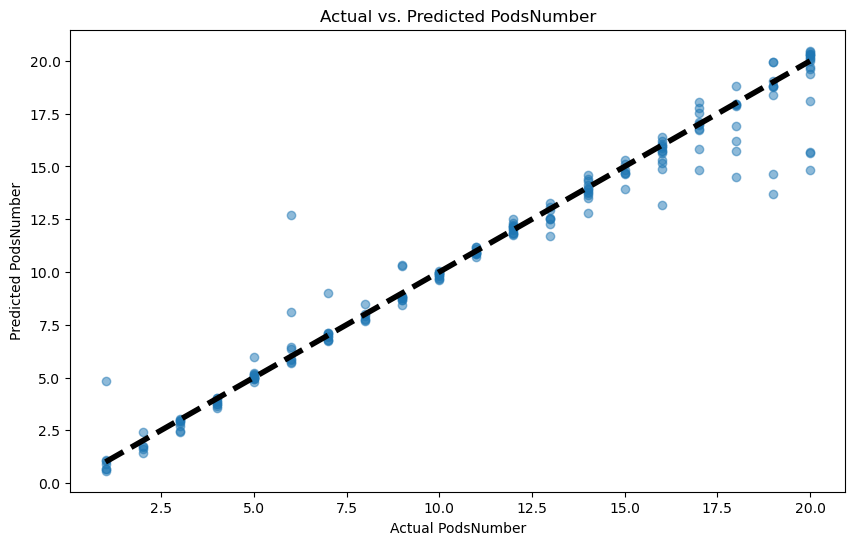

In [176]:
import matplotlib.pyplot as plt

# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual PodsNumber')
plt.ylabel('Predicted PodsNumber')
plt.title('Actual vs. Predicted PodsNumber')
plt.show()


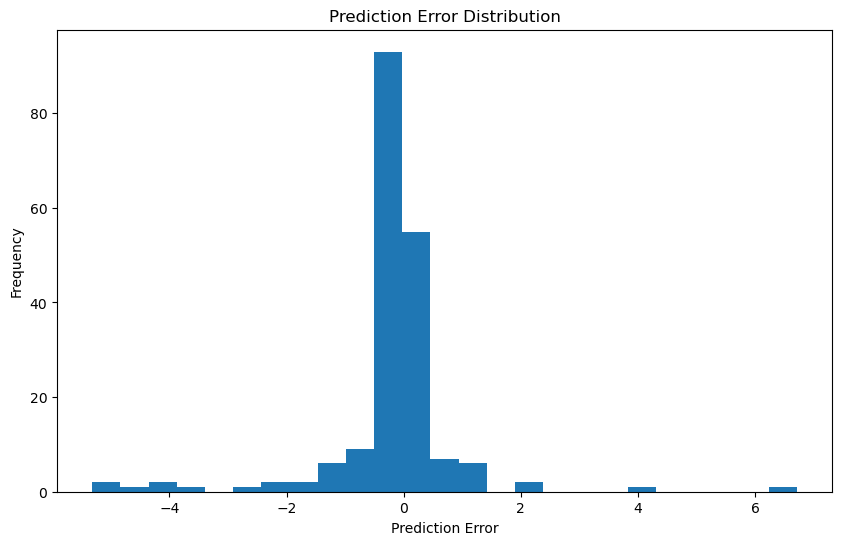

In [177]:
errors = predictions.flatten() - y_test
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=25)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Prediction Error Distribution')
plt.show()


In [178]:
# check feature names stored in the scaler 
if hasattr(scaler, 'feature_names_in_'):
    print("Features used during scaler fitting:", scaler.feature_names_in_)



Features used during scaler fitting: ['CPU_Mean' 'PackRecv_Mean' 'StressRate_Mean' 'CPU_Pack_Ratio_Log']
